In [ ]:
import json
data_path_1_SFT = 'KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

Text(0.5, 1.0, 'length of completion')

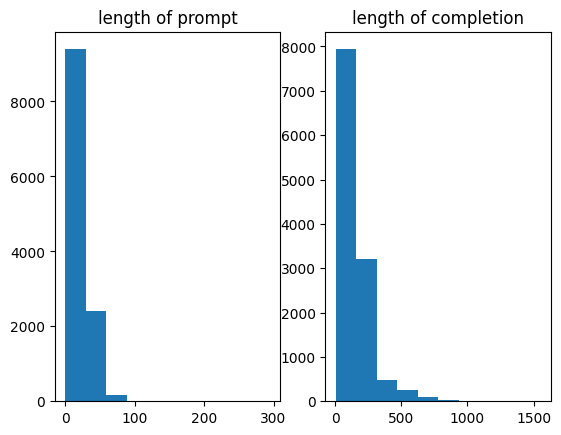

In [ ]:
lens_prompt=[len(x['prompt']) for x in list_data_dict]
lens_comp=[len(x['completion']) for x in list_data_dict]

import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.hist(lens_prompt)
plt.title('length of prompt')

plt.subplot(1,2,2)
plt.hist(lens_comp)
plt.title('length of completion')

중복된 (prompt, completion) 쌍을 제거했어요.

너무 짧거나 (prompt < 5, completion < 3) / 너무 긴 데이터 (prompt > 512, completion > 1024) 를 걸러냈습니다.

모든 completion 문장이 </s> 토큰으로 끝나도록 통일시켰습니다.

이 과정을 통해 품질이 낮거나 모델 학습에 방해가 될 수 있는 데이터를 제거하고, 학습 안정성과 성능 향상을 기대할 수 있습니다.

In [ ]:
seen=set()
sft_clean=[]
for x in list_data_dict:
  prompt=x['prompt'].strip()
  completion=x['completion'].strip()

  key=(prompt, completion)
  if key in seen:
    continue
  seen.add(key)

  if len(prompt)<5:
    continue
  if len(completion)<3:
    continue

  if len(prompt)>512:
    continue
  if len(completion)>1024:
    continue

  if not completion.endswith('</s>'):
    completion = completion + "</s>"

  sft_clean.append({'prompt':prompt, 'completion':completion})

out_path= "KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.clean.jsonl"
with open(out_path, 'w') as f:
  json.dump(sft_clean, f, ensure_ascii=False, indent=2)

print("SFT before:", len(list_data_dict), "after:", len(sft_clean))


SFT before: 12000 after: 11868


In [ ]:
import json
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import torch
from peft import LoraConfig, get_peft_model


데이터 처리 방식

처음에는 DataCollatorForSupervisedDataset을 사용해서 input_ids와 labels를 따로 패딩했음.

지금은 CausalLMDataCollator를 직접 정의해서 tokenizer.pad()로 한 번에 패딩하고, attention_mask==0인 부분을 -100으로 마스킹하도록 변경함.

학습 설정(TrainingArguments)

원래는 num_train_epochs=1, batch_size=8, warmup_steps=5, prediction_loss_only=True 등 간단한 설정.

지금은 num_train_epochs=2, batch_size=2, gradient_accumulation_steps=8, warmup_steps=200, weight_decay=0.01 등 더 정교한 설정으로 바꿈.

또한 logging_steps, eval_steps, save_steps, save_total_limit 등을 추가해 학습 과정을 더 세밀하게 관리.

In [ ]:
wsft_data=json.load(f)
ith open('KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.clean.jsonl', 'r') as f:

def format_row(r):
    return {"text": f"### Instruction:\n{r['prompt']}\n\n### Response:\n{r['completion']}"}

dataset = Dataset.from_list([format_row(r) for r in sft_data])
dataset = dataset.train_test_split(test_size=0.05, seed=42)

base_model="skt/kogpt2-base-v2"
tokenizer=AutoTokenizer.from_pretrained(base_model, bos_token="</s>", eos_token="</s>", unk_token="</s>", pad_token="</s>")
tokenizer.model_max_length=512
tokenizer.padding_side="right"

def tokenize(batch):
  return tokenizer(batch['text'], truncation=True, max_length=512)

dataset_tok=dataset.map(tokenize, batched=True)
dataset_tok=dataset_tok.remove_columns('text')

model = AutoModelForCausalLM.from_pretrained(base_model)

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj", "mlp.c_fc", "mlp.c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)

model.config.use_cache = False

class CausalLMDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):

        batch = self.tokenizer.pad(
            features,
            padding=True,
            return_tensors="pt"
        )

        labels = batch["input_ids"].clone()
        labels[batch["attention_mask"] == 0] = -100
        batch["labels"] = labels
        return batch

data_collator = CausalLMDataCollator(tokenizer)

trainable, all_params = 0, 0
for name, param in model.named_parameters():
    all_params += param.numel()
    if param.requires_grad:
        trainable += param.numel()
        print("✅ trainable:", name, param.shape)

print(f"\nTrainable params: {trainable:,} / {all_params:,} "
      f"({100 * trainable/all_params:.2f}%)")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/11274 [00:00<?, ? examples/s]

Map:   0%|          | 0/594 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/513M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


✅ trainable: base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight torch.Size([16, 768])
✅ trainable: base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight torch.Size([2304, 16])
✅ trainable: base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight torch.Size([16, 768])
✅ trainable: base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight torch.Size([768, 16])
✅ trainable: base_model.model.transformer.h.0.mlp.c_fc.lora_A.default.weight torch.Size([16, 768])
✅ trainable: base_model.model.transformer.h.0.mlp.c_fc.lora_B.default.weight torch.Size([3072, 16])
✅ trainable: base_model.model.transformer.h.0.mlp.c_proj.lora_A.default.weight torch.Size([16, 3072])
✅ trainable: base_model.model.transformer.h.0.mlp.c_proj.lora_B.default.weight torch.Size([768, 16])
✅ trainable: base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight torch.Size([16, 768])
✅ trainable: base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight torch.S

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="models/kogpt2-base-v2",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=5e-5,
    num_train_epochs=2,
    warmup_steps=200,
    weight_decay=0.01,
    logging_steps=50,
    eval_steps=200,
    save_steps=200,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    group_by_length=True,
    dataloader_num_workers=2,
    remove_unused_columns=False,
    report_to="none"
)

from transformers import Trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tok["train"],
    eval_dataset=dataset_tok["test"],
    data_collator=data_collator
)

In [ ]:
trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
50,4.401500
100,3.467400
150,2.969900
200,2.708600
250,2.564400
300,2.505900
350,2.497300
400,2.438700
450,2.426200
500,2.386500


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=1410, training_loss=2.5106227780064794, metrics={'train_runtime': 744.5525, 'train_samples_per_second': 30.284, 'train_steps_per_second': 1.894, 'total_flos': 1039769280479232.0, 'train_loss': 2.5106227780064794, 'epoch': 2.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_dir = "/content/drive/MyDrive/KoChatGPT/output_SFT_trinity345M_dynpad"

trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

('/content/drive/MyDrive/KoChatGPT/output_SFT_trinity345M_dynpad/tokenizer_config.json',
 '/content/drive/MyDrive/KoChatGPT/output_SFT_trinity345M_dynpad/special_tokens_map.json',
 '/content/drive/MyDrive/KoChatGPT/output_SFT_trinity345M_dynpad/vocab.json',
 '/content/drive/MyDrive/KoChatGPT/output_SFT_trinity345M_dynpad/merges.txt',
 '/content/drive/MyDrive/KoChatGPT/output_SFT_trinity345M_dynpad/added_tokens.json',
 '/content/drive/MyDrive/KoChatGPT/output_SFT_trinity345M_dynpad/tokenizer.json')

In [ ]:
dataset_tok['test']


Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 594
})

do_sample=False, num_beams=5, repetition_penalty=1.1 등 더 보수적이고 결정적인 생성으로 설정.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

save_dir = "/content/drive/MyDrive/KoChatGPT/output_SFT_trinity345M_dynpad"
base_model_id = "skt/kogpt2-base-v2"

tokenizer = AutoTokenizer.from_pretrained(save_dir)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id)
model = PeftModel.from_pretrained(base_model, save_dir).eval()

INSTR = "### Instruction:\n"
RESP  = "\n\n### Response:\n"

n_samples = 10
for i in range(n_samples):
    row = dataset["test"][i]
    full_text = row["text"]

    assert full_text.startswith(INSTR)
    body = full_text[len(INSTR):]
    prompt_part, target_part = body.split(RESP, 1)

    prompt_for_model = f"{INSTR}{prompt_part}{RESP}"

    inputs = tokenizer(prompt_for_model, return_tensors="pt")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            do_sample=False,
            #top_p=0.9,
            #temperature=0.7,
            length_penalty=1.0,
            repetition_penalty=1.1,
            num_beams=5,
            no_repeat_ngram_size=2
        )
    generated_full = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_resp = generated_full.replace(prompt_for_model, "").strip()

    print(f"\n==== Test Example {i+1} ====")
    print("Prompt:", prompt_part)
    print("Target completion:", target_part.strip())
    print("Generated:", generated_resp)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



==== Test Example 1 ====
Prompt: 탈모예방 샴푸 추천해주세요
Target completion: '저는 인공지능 기반 챗봇으로 자연어 이해 기술만을 갖고 있어 제품에 대한 추천을 제공할 수 없습니다. 하지만 다른 방법으로 효과적인 탈모 예방 샴푸를 찾으실 수 있습니다.\n\n1. 올바른 샴푸 선택: 탈모예방을 위해서는 다양한 성분이 함유된 샴푸보다, 탈모 예방 성분이 함유된 샴푸를 선택해야합니다. 디프언스 샴푸, 미노디엑스 샴푸, RCP 샴푸 등이 탈모 예방에 효과적인 샴푸입니다.\n\n2. 천연원료 샴푸 사용: 화학성분을 가지지 않은 천연성분으로 이루어진 샴푸도 탈모 예방에 효과적입니다. 녹차, 홍삼, 아보카도 등이 함유된 천연성분 샴푸를 선택해보세요.\n\n3. 적극적인 스케일링: 올바른 스케일링을 통해 지속적으로 탈모 예방을 할 수 있습니다. 자주 스케일링을 하여 머리카락에 노폐물을 제거하고, 두피 피부의 혈액순환을 촉진하여 탈모 예방에 효과적입니다.\n\n4. 올바른 건강한 식습관: 올바른 식습관과 섭취량, 수분 섭취량을 지켜주는 것도 탈모 예방에 효과적입니다. 식습관에 유의하여 건강한 머리카락을 유지하세요.\n\n5. 숙면과 스트레스 관리: 숙면과 스트레스 관리 또한 두피 건강에 중요합니다. 충분한 수면과 스트레스를 관리하여 건강한 머리카락을 유지하세요. \n\n이러한 방법을 적극적으로 적용하시면 탈모 예방에 큰 도움이 됩니다.</s>
Generated: '저는 인공지능 어시스턴트이기 때문에 탈모예방에 도움이 될 수 있는 제품을 추천드립니다.

==== Test Example 2 ====
Prompt: 좋아하는 애 피하면서도 우울해.
Target completion: '그 애가 왜 피하는지 알고 있다면 그 이유에 대해 생각해보는 것이 도움이 될 수 있습니다. 그리고 그 애와의 관계를 개선하려는 노력을 기울여 보는 것도 좋은 방법입니다. 그렇지만 그 애와 접하는 것이 힘들다면, 다른 사람들과 함께 시간을 보내거나 다른 취미를 찾

In [ ]:
dataset['test']

Dataset({
    features: ['text'],
    num_rows: 594
})

이전 모델은 거의 모든 질문에 부정확하거나 엉뚱한 답변을 길게 생성했고, 사실과 맞지 않는 정보가 많았음.

현재 모델은 Instruction–Response 형식을 따르며 답변이 좀 더 간결해졌지만, 여전히 “저는 인공지능 어시스턴트이기 때문에 …”라는 회피형 응답이 많음.

일부 질문(예: 탈모 샴푸, 세렝게티 우기 등)에서는 어느 정도 관련 있는 내용을 포함했으나, 사실 정확도는 여전히 낮음.